# `InfiniteOpt.jl`: New Formulation Strategies
Now that we are familiar with `InfiniteOpt.jl`, let's discuss how its unifying abstraction enables new formulation techniques.

![abstract](../figures/abstract.png)

## Case Study: Pandemic Control
To have a motivating example to work with and get some practice, let's consider a pandemic control problem.

### Formulation
We wish to determine optimal social distancing policy to control spread of a contagion and minimize the economic impact of doing so. We'll model the spread of the virus through a given population using the SEIR Model which considers 4 population subsets that follow:
$$
\text{Susceptible} \rightarrow \text{Exposed} \rightarrow \text{Infectious} \rightarrow \text{Recovered}
$$
The formulation is given by:
$$
\begin{aligned}
&&\min_{} &&& \int_{t \in \mathcal{D}_{t}} u(t) dt \\
&& \text{s.t.} &&& \frac{d s(t)}{d t} = (u(t) - 1)\beta s(i)i(t), && t \in \mathcal{D}_{t} \\
&&&&& \frac{d e(t)}{d t} = (1 - u(t))\beta s(t)i(t) - \xi e(t), && t \in \mathcal{D}_{t} \\
&&&&& \frac{d i(t)}{dl t} = \xi e(t) - \gamma i(t), && t \in \mathcal{D}_{t} \\
&&&&& \frac{d r(t)}{d t} = \gamma i(t), && t \in \mathcal{D}_{t} \\
&&&&& i(t) \leq i_{max}, && t \in \mathcal{D}_{t} \\
&&&&& u(t) \in [0, 0.8], && t \in \mathcal{D}_{t} \\
&&&&& s(t),e(t),i(t),r(t) \in [0, 1], && t \in \mathcal{D}_{t} \\
&&&&& s(0) = s_0, e(0) = e_0, i(0) = i_0, r(0) = r_0
\end{aligned}
$$
Here $s(t)$, $e(t)$, $i(t)$, and $r(t)$ are state variables. The control variable $u(t)$ seeks to enforce an isolation policy on the population.

### Exercise: Implement it!
**Problem**
- Complete the model below

In [1]:
using InfiniteOpt, Ipopt

# Set the parameters
γ = 0.303
β = 0.727
N = 1e5
ξ = 0.3
i_max = 0.02
extra_ts = [0.001, 0.002, 0.004, 0.008, 0.02, 0.04, 0.08, 0.2, 0.4, 0.8]
e0 = 1 / N
i0 = 0
r0 = 0
s0 = 1 - e0;

In [4]:
# Define the model with the Ipopt optimizer
model = InfiniteModel(Ipopt.Optimizer) # Finish
set_time_limit_sec(model, 10)

# Add the infinite parameter
@infinite_parameter(model, t ∈ [0, 200], num_supports = 101) # t ∈ [0, 200] with 101 supports
add_supports(t, extra_ts)

# Add the variables
@variable(model, 0 ≤ s ≤ 1, Infinite(t)) # 0 ≤ s(t) ≤ 1
@variable(model, 0 ≤ e ≤ 1, Infinite(t)) # 0 ≤ e(t) ≤ 1
@variable(model, 0 ≤ i ≤ i_max, Infinite(t)) # 0 ≤ i(t) ≤ i_max
@variable(model, 0 ≤ r ≤ 1, Infinite(t)) # 0 ≤ r(t) ≤ 1
@variable(model, 0 ≤ u ≤ 0.8, Infinite(t), start = 0.5) # 0 ≤ u(t) ≤ 0.8 with guess of 0.5

# Add the objective
@objective(model, Min, ∫(u, t)) # minimize ∫_{t ∈ [0, 200]} u(t) dt

# Add the initial conditions
fix(s(0), s0, force = true) # add s(0)
fix(e(0), e0, force = true) # add e(0)
fix(i(0), i0, force = true) # add i(0)
fix(r(0), r0, force = true) # add r(0)

# Define the SEIR equations
@constraint(model, ∂(s, t) == -(1 - u) * β * s * i) # d/dt[s(t)] = -(1 - u(t))βs(t)i(t)
@constraint(model, ∂(e, t) == (1 - u) * β * s * i - ξ * e) # d/dt[e(t)] = (1 - u(t))βs(t)i(t) - ξe(t)
@constraint(model, ∂(i, t) == ξ * e - γ * i) # d/dt[i(t)] = ξe(t) - γi(t)
@constraint(model, ∂(r, t) == γ * i) # d/dt[r(t)] = γi(t)

# Print the model 
latex_formulation(model)

$$ \begin{aligned}
\min\quad & \int_{t \in [0, 200]}u(t)dt\\
\text{Subject to} \quad & s(t) \geq 0.0, \quad\forall t \in [0, 200]\\
 & s(t) \leq 1.0, \quad\forall t \in [0, 200]\\
 & e(t) \geq 0.0, \quad\forall t \in [0, 200]\\
 & e(t) \leq 1.0, \quad\forall t \in [0, 200]\\
 & i(t) \geq 0.0, \quad\forall t \in [0, 200]\\
 & i(t) \leq 0.02, \quad\forall t \in [0, 200]\\
 & r(t) \geq 0.0, \quad\forall t \in [0, 200]\\
 & r(t) \leq 1.0, \quad\forall t \in [0, 200]\\
 & u(t) \geq 0.0, \quad\forall t \in [0, 200]\\
 & u(t) \leq 0.8, \quad\forall t \in [0, 200]\\
 & s(0) = 0.99999\\
 & e(0) = 1.0e-5\\
 & i(0) = 0.0\\
 & r(0) = 0.0\\
 & (0.727 i(t)*s(t) + d/dt[s(t)]) - (0.727 u(t)*s(t)) * i(t) = 0.0, \quad\forall t \in [0, 200]\\
 & (-0.727 i(t)*s(t) + d/dt[e(t)]) + (0.727 u(t)*s(t)) * i(t) + 0.3 e(t) = 0.0, \quad\forall t \in [0, 200]\\
 & \frac{\partial}{\partial t}\left[i(t)\right] - 0.3 e(t) + 0.303 i(t) = 0.0, \quad\forall t \in [0, 200]\\
 & \frac{\partial}{\partial t}\left[r(t)\right]

In [5]:
optimize!(model)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     2862
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1322

Total number of variables............................:      995
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      551
                     variables with only upper bounds:        0
Total number of equality constraints.................:      884
Total number of inequality co

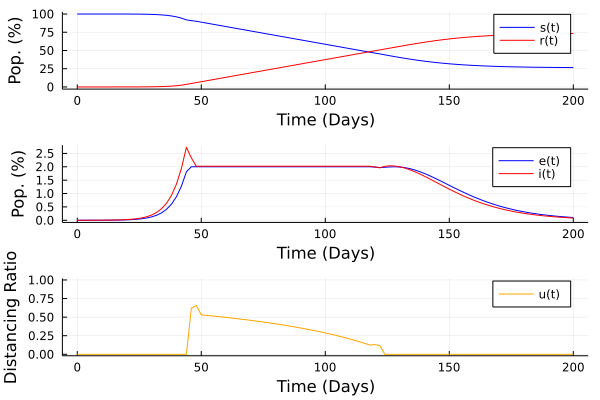

In [7]:
using Plots

function plot_solution(model)
    has_values(model) || error("No solution!")

    # Get the solution
    s_opt = value(s) * 100 # values of s(t) * 100
    i_opt = value(e) * 100 # values of e(t) * 100
    e_opt = value(i) * 100 # values of i(t) * 100
    r_opt = value(r) * 100 # values of r(t) * 100
    u_opt = value(u) # values of u(t)
    ts = value(t) # values of t

    # Plot s(t) and r(t)
    p1 = plot(ts, s_opt, label = "s(t)", linecolor = :blue)
    plot!(ts, r_opt, label = "r(t)", linecolor = :red)
    ylabel!("Pop. (%)")
    xlabel!("Time (Days)")

    # Plot e(t) and i(t)
    p2 = plot(ts, e_opt, label = "e(t)", linecolor = :blue)
    plot!(ts, i_opt, label = "i(t)", linecolor = :red)
    ylabel!("Pop. (%)")
    xlabel!("Time (Days)")

    # Plot u(t)
    p3 = plot(ts, u_opt, linecolor = :orange, label = "u(t)", ylims = (-0.02, 1.02))
    xlabel!("Time (Days)")
    ylabel!("Distancing Ratio")

    return plot(p1, p2, p3, layout = (3,1))
end

plot_solution(model)

## Dynamic Risk Measures
Following our unifying abstraction, we can transfer concepts from one field of optimization to another. We'll see how this is the case with transferring risk measures from stochastic optimization to dynamic optimization.

### Time-Valued Expectations
Recall that `InfiniteOpt.jl` natively provides integral and expectation measures. What if we tried changing the objective function in the above example to use `𝔼` instead of `∫`?

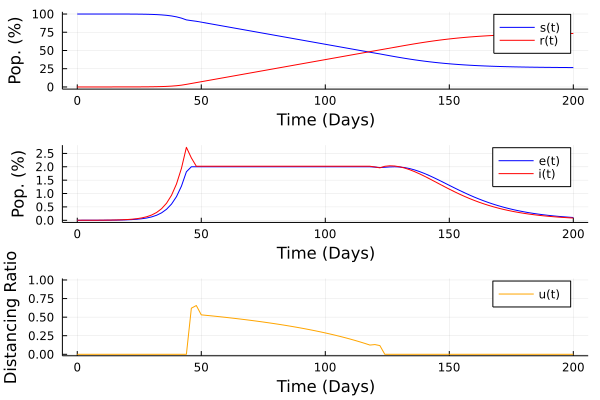

In [9]:
@objective(model, Min, 𝔼(u, t))
set_silent(model)

optimize!(model)

plot_solution(model)

We get the same solution, but why? Let's look at the math. The expectation measure in time is:
$$
\mathbb{E}_t[u(t)] = \int_{t_0}^{t_f} u(t) p(t) dt
$$
where $p(t)$ is the time-valued pdf function which by default is $p(t) = \frac{1}{t_f - t_0}$. Hence, this is scaled by a constant $\frac{1}{t_f - t_0}$, but is otherwise equivalent to the integral.

However, we can choose other pdfs. Let's try $p(t) = \exp(-t)$ and see what happens:

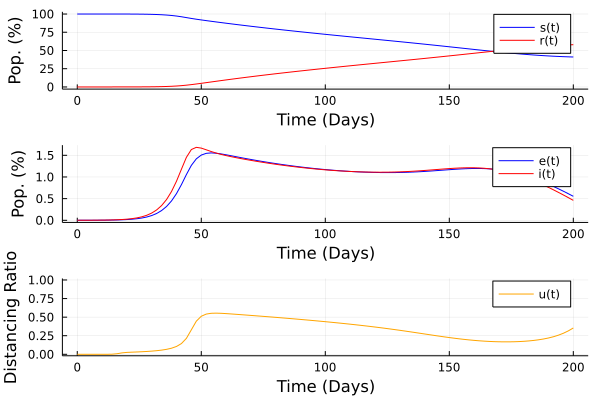

In [10]:
@objective(model, Min, 𝔼(u, t, pdf = t -> exp(-t)))

optimize!(model)

plot_solution(model)

The answer is different! Now the emphasis is placed on the beginning of the trajectory which leads to a new shape. Our choice of measure helps shape the optimal trajectories.

We can envision adapting other pdfs from distributions to a time context and shaping the trajectories in other ways. 

#### Exercise: Varying pdfs
**Problem**
- Vary the pdf and see what happens
- Try $p(t) = \exp(-(t - 100)^2)$
- Try $p(t) = t$
- Try something else

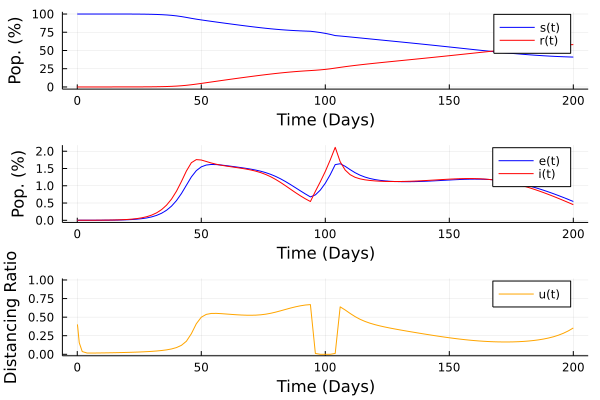

In [11]:
p(t) = exp(-(t - 100)^2) # PUT FUNCTION HERE

@objective(model, Min, 𝔼(u, t, pdf = p))

optimize!(model)

plot_solution(model)

A key observation is that expectations are one kind of *risk measure* from stochastic optimization. If this one works for time functions, what about other risk measures?

### Mean-Variance Measures
Another risk measure is the mean-variance measure which using a time-valued expectation becomes:
$$
\mathbb{E}\text{-}\mathbb{V}_t[u(t)] = \mathbb{E}_t[u(t)] + \lambda \mathbb{E}_t\left[(u(t) - \mathbb{E}_t[u(t)])^2\right]
$$
where $\lambda \in \mathbb{R}_+$ is a tradeoff parameter. Let's see what this does to our problem.

#### Exercise: Implement it
**Problem**
- Implement $\mathbb{E}\text{-}\mathbb{V}_t[u(t)]$
- Vary $\lambda$ between 0.1 and 100

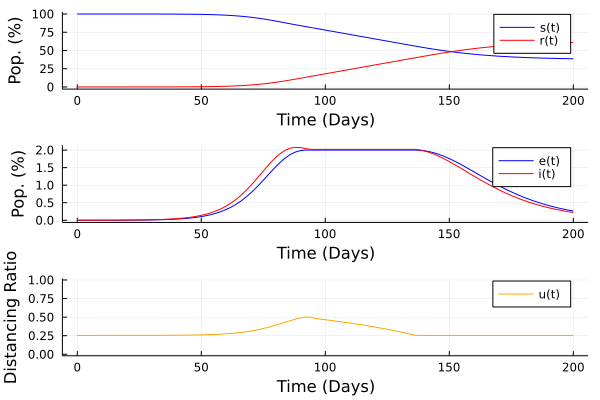

In [12]:
# PUT THE OBJECTIVE HERE
λ = 10
@objective(model, Min, 𝔼(u, t) + λ * 𝔼((u - 𝔼(u, t))^2, t))

optimize!(model)

plot_solution(model)

The variance term has the effect of smoothing our control trajectory. We can imagine what varying the pdf might do, but we'll save that for another day.

### Conditional-Value-at-Risk (CVaR)
One very popular risk measure is CVaR, because it penalizes high costs (not the low ones) in contrast to mean-variance which penalizes both. CVaR is defined:
$$
\text{CVaR}_t(u(t); \alpha) = \underset{z \in \mathbb{R}}{\text{inf}}\left\{z + \frac{1}{1-\alpha} \mathbb{E}_t[\text{max}(0, u(t) - z)] \right\}
$$
where $\alpha \in [0, 1)$ what fraction of peak values are penalized. For a minimization problem, this can be reformulated into:
$$
\begin{aligned}
&&\min &&& z + \frac{1}{1-\alpha} \mathbb{E}_t[q(t)] \\
&&\text{s.t.} &&& q(t) \geq u(t) - z, && t \in \mathcal{D}_t\\
&&&&& q(t) \geq 0, && t \in \mathcal{D}_t\\
\end{aligned}
$$
Let's implement it!

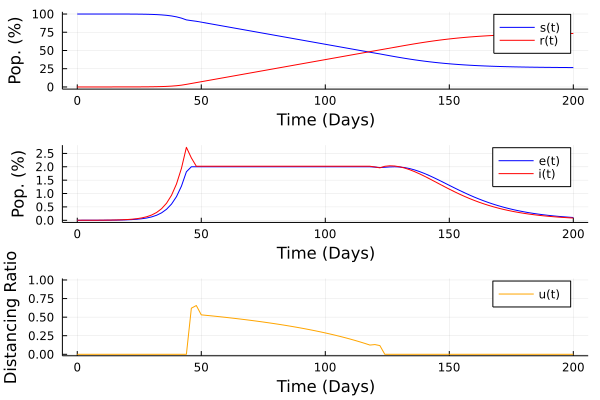

In [13]:
@finite_parameter(model, α == 0)
@variable(model, z)
@variable(model, q ≥ 0, Infinite(t))
@objective(model, Min, z + 1 / (1 - α) * 𝔼(q, t))
@constraint(model, q ≥ u - z)

optimize!(model)

plot_solution(model)

Ok, $\alpha = 0$ gave us the same result as using the integral.

#### Exercise: CVaR
**Problem**
- Vary the value of $\alpha$ and see the effects

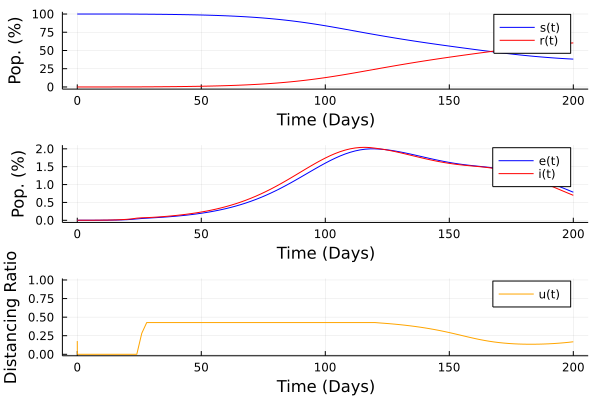

In [15]:
set_value(α, 0.85) # change the value

optimize!(model)

plot_solution(model)